# **Part A**
Count / Frequency based Naive Bayes Classifier

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # Calculate Class Prior P(C): log(P(C))
            self.class_priors[c] = np.log(X_c.shape[0] / X_counts.shape[0])

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing
            numerator = feature_sum + self.alpha
            denominator = total_mass + self.alpha * self.vocabulary_size

            # Calculate the log likelihood
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # Add log likelihoods contribution (Log-Sum Trick)
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])
                scores[c] = log_prob

            # Find the key (class label) with the maximum score
            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        # Return the final predictions array
        return np.array(y_pred)


In [11]:
def load_pubmed_rct_file(filepath):
    """
    Loads PubMed RCT data from a .txt file.
    Each line is expected to be in the format: <label>\t<sentence>
    Returns a DataFrame with columns: 'label' and 'sentence'
    """
    labels = []
    sentences = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                labels.append(parts[0])
                sentences.append(parts[1])
    return pd.DataFrame({'label': labels, 'sentence': sentences})

In [12]:
from google.colab import files
uploaded = files.upload()

Saving dev.txt to dev (1).txt
Saving test.txt to test (1).txt
Saving train.txt to train (1).txt


In [13]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    #train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    #dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    #test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})


    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [14]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 2),  # Use unigrams and bigrams
        min_df=2             # Ignore words that appear in fewer than 2 documents
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)

    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier()

    # Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")

Fitting Count Vectorizer and transforming training data...
Vocabulary size: 301234
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7571
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.56      0.57      3621
 CONCLUSIONS       0.63      0.69      0.66      4571
     METHODS       0.81      0.89      0.85      9897
   OBJECTIVE       0.60      0.43      0.50      2333
     RESULTS       0.87      0.80      0.84      9713

    accuracy                           0.76     30135
   macro avg       0.70      0.68      0.68     30135
weighted avg       0.76      0.76      0.75     30135

Macro-averaged F1 score: 0.6825


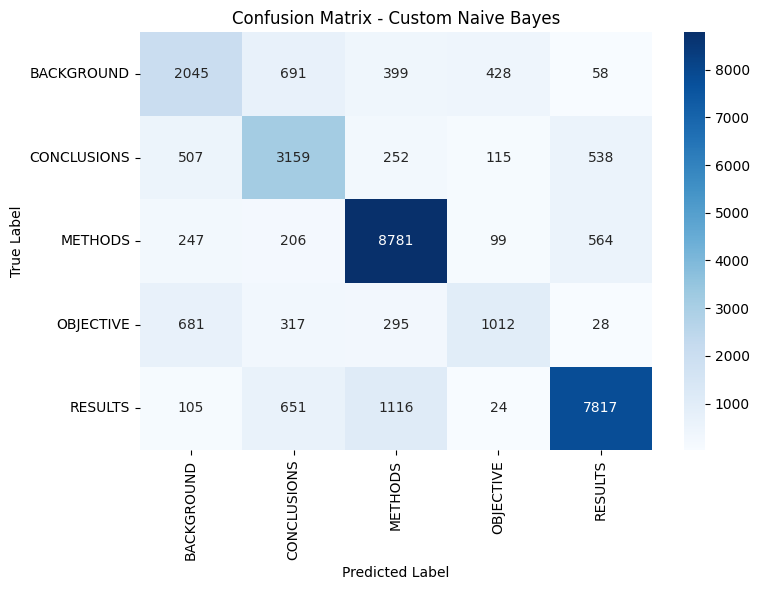

In [21]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Custom Naive Bayes')
    plt.tight_layout()
    plt.show()
else:
    print("Prediction step failed or incomplete.")



=== Confusion Matrix (Custom Naive Bayes) ===


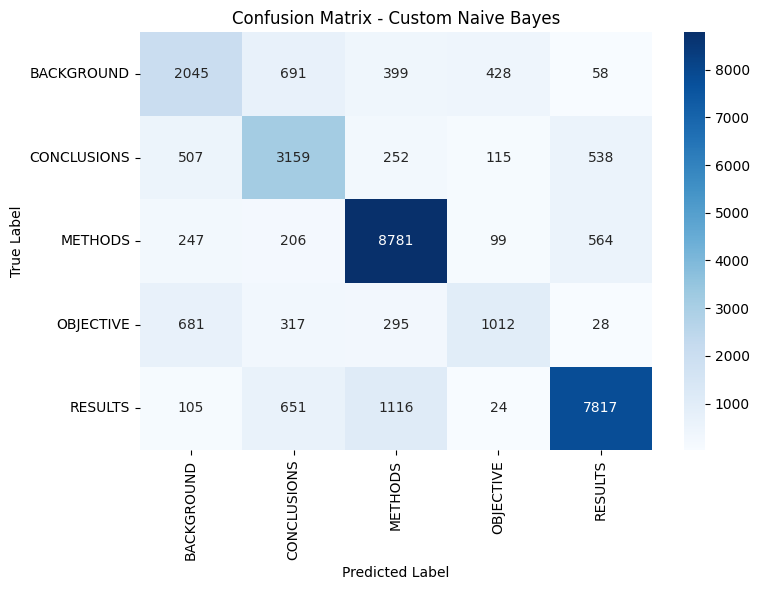

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix on test set
if y_test_pred is not None:
    print("\n=== Confusion Matrix (Custom Naive Bayes) ===")

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)

    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Custom Naive Bayes')
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix cannot be displayed: No predictions available.")

# **Part B**
TF-IDF score based Classifier

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Step 1: Define the initial pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english'
    )),
    ('nb', MultinomialNB())
])

# Step 2: Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")

# Step 3: Predict and evaluate on test set
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)
if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")

# Step 4: Define the parameter grid for hyperparameter tuning
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]
}

# Step 5: Initialize GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

# Step 6: Fit the GridSearchCV object using the development data
print("\nStarting Hyperparameter Tuning on Development Set...")
grid.fit(X_dev, y_dev)
print("Grid search complete.")

# Step 7: Print the best parameters and score
if grid is not None and hasattr(grid, 'best_params_'):
    print("\n=== Best Hyperparameters Found ===")
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best Macro F1 Score: {grid.best_score_:.4f}")
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.6996
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.37      0.46      3621
 CONCLUSIONS       0.61      0.55      0.57      4571
     METHODS       0.68      0.88      0.77      9897
   OBJECTIVE       0.72      0.09      0.16      2333
     RESULTS       0.77      0.85      0.81      9713

    accuracy                           0.70     30135
   macro avg       0.68      0.55      0.56     30135
weighted avg       0.69      0.70      0.67     30135

Macro-averaged F1 score: 0.5555

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Grid search complete.

=== Best Hyperparameters Found ===
Best Parameters: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}
Best Macro F1 Score: 0.5925


# **Part C**
Bayes Optimal Classifier

Part C Draft

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS197
Using dynamic sample size: 10197
Actual sampled training set size used: 10197

Training all base models...
All base models trained.

Calculating Posterior Weights...
Posterior Weights: [0.22854849 0.2419911  0.21283976 0.17378258 0.14283806]

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.6965
              precision    recall  f1-score   support

  BACKGROUND       0.59      0.30      0.40      3621
 CONCLUSIONS       0.60      0.52      0.56      4571
     METHODS       0.68      0.89      0.77      9897
   OBJECTIVE       0.70      0.34      0.45      2333
     RESULTS       0.78      0.81      0.80      9713

    accuracy                           0.70     30135
   macro avg       0.67      0.57      0.59     30135
weighted avg       0.69      0.70      0.68     30135

Macro-averaged F1 score:

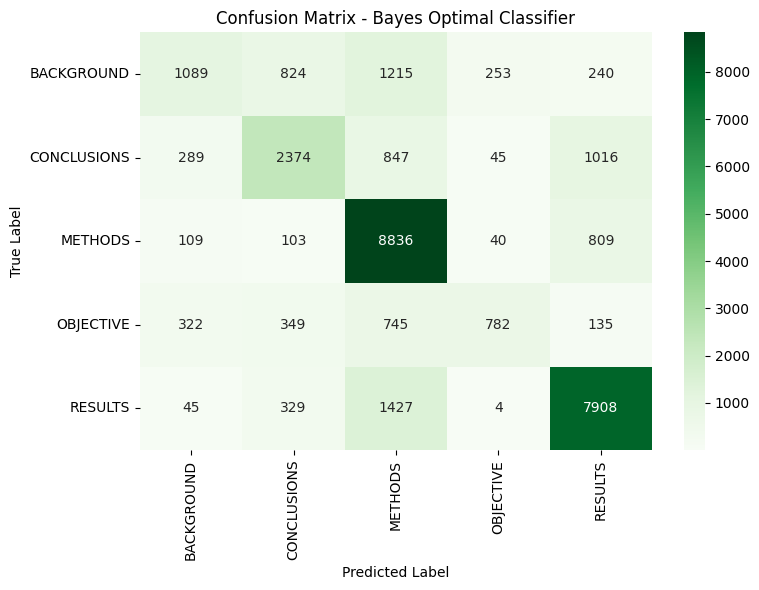

In [20]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split # Used for P(h|D) calculation

# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000

# Prompt the user for their full SRN
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    # Extract the last three characters and convert to integer
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        # Fallback if input is too short
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    # Fallback if SRN is not entered or format is incorrect
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

# Calculate the final sample size: 10000 + last three SRN digits
SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")


# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1), # Using unigrams only to keep feature space small for diverse models
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines (DO NOT CHANGE)

# H1: Multinomial Naive Bayes
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

# H2: Logistic Regression
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))
])


# H3: Random Forest Classifier
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])

# H4: Decision Tree Classifier
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

# H5: K-Nearest Neighbors
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']


# Training and BOC Implementation (STUDENT TASK)

# Step 1: Train all five hypotheses
print("\nTraining all base models...")
for model in hypotheses:
    model.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")

# Step 2: Posterior Weight Calculation
print("\nCalculating Posterior Weights...")
X_sub_train, X_val, y_sub_train, y_val = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42
)

log_likelihoods = []
for model in hypotheses:
    model.fit(X_sub_train, y_sub_train)
    y_proba = model.predict_proba(X_val)
    loss = log_loss(y_val, y_proba, labels=target_names)
    log_likelihoods.append(-loss)  # Negative log loss as proxy for log-likelihood

# Normalize to get posterior weights
exp_scores = np.exp(log_likelihoods)
posterior_weights = exp_scores / np.sum(exp_scores)
print(f"Posterior Weights: {posterior_weights}")

# Step 3: Fit the VotingClassifier
estimators = list(zip(hypothesis_names, hypotheses))
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")

# Step 4: Predict and Evaluate
print("\nPredicting on test set...")
y_pred = boc_soft_voter.predict(X_test)

print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=target_names))
print(f"Macro-averaged F1 score: {f1_score(y_test, y_pred, average='macro'):.4f}")

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred, labels=target_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Bayes Optimal Classifier')
plt.tight_layout()
plt.show()
